In [ ]:
"""
-*- coding: utf-8 -*-
 Original file by the CIL team:
https://github.com/TomographicImaging/CIL-Demos/blob/main/demos/2_Iterative/05_Laminography_with_TV.ipynb   

"""

In [12]:
%load_ext autoreload
%autoreload 2

import cil
print(f"Using CIL version {cil.__version__}")

from cil.framework import AcquisitionGeometry

from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import ZeroFunction, LeastSquares, TotalVariation

from cil.io import TIFFStackReader

from cil.processors import TransmissionAbsorptionConverter, Binner, Normaliser

# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra import ProjectionOperator
from cil.recon import FDK

from cil.plugins.ccpi_regularisation.functions import FGP_TV

from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer

import numpy as np
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CIL version 24.3.0


### Read CL parameters

In [2]:
from util.pcaReader import read_pca_file


filepath = "../keyboard_4/keyboard_4.pca"
params = read_pca_file(filepath=filepath)
params

72 lines, found 53 values (discarded 25)


{'Version-pca': '2\n',
 'FDD': 650.1999701125958,
 'FOD': 93.5226587597524,
 'cx': 517.0070660992587,
 'cy': 490.5149799815266,
 'CalibValue': -33.65098318912923,
 'DetectorRot': -0.08553882529839198,
 'Tilt': 44.9741793137597,
 'Oblique': 45.0,
 'NumberImages': 758,
 'StartImg': 1,
 'RotationSector': 360.0,
 'PlanarCTRotCenter': 0.0,
 'ROILowerHeight': -74.0,
 'ROIUpperHeight': 74.0,
 'ROIWidthX': 707.0,
 'ROIWidthY': 707.0,
 'ROIOffsetX': 0.0,
 'ROIOffsetY': 0.0,
 'DimX': 1000.0,
 'DimY': 1000.0,
 'FreeRay': 1992,
 'PixelsizeX': 0.2,
 'PixelsizeY': 0.2,
 'Voltage': 100.0,
 'Current': 80.0,
 'CenterX': 245.31154921,
 'CenterY': 180.43867718}

In [3]:
from util.getParameters import get_cl_parameters

SOD,\
SDD,\
ODD,\
pixel_size,\
num_pixels,\
num_projs,\
intensity,\
tilt,\
angles_list,\
rotation_axis,\
height_offset = get_cl_parameters(params)

SOD: 93.523 mm
SDD: 650.200 mm
ODD: 556.677 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
758 projection angles used
White level intensity: 1992
Tilt angle in radians: 0.7849475074074306


### Set Acquisition geometry

In [4]:
from util.setAcquisitionGeometry import set_cl_acquisition_geometry

ag = set_cl_acquisition_geometry(params=params, origin="top-left")


SOD: 93.523 mm
SDD: 650.200 mm
ODD: 556.677 mm
Detector pixel size: 0.200 mm
Projection image size: 1000 x 1000
758 projection angles used
White level intensity: 1992
Tilt angle in radians: 0.7849475074074306
3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -650.19997011,    0.        ]
	Rotation axis position: [ 0., -0.,  0.]
	Rotation axis direction: [-0.        ,  0.70678805, -0.70742537]
	Detector position: [  0.        , 556.67731135,   0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1000 1000]
	Pixel size: [0.2 0.2]
	Pixel origin: top-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 758
	Angles 0-9 in degrees: [0.        , 0.47493404, 0.9498681 , 1.4248021 , 1.8997362 , 2.3746703 ,
 2.8496041 , 3.3245382 , 3.7994723 , 4.2744064 ]
	Angles 748-757 in degrees: [355.25067, 355.7256 , 356.20053, 356.67548, 357.1504 , 357.62534,
 3

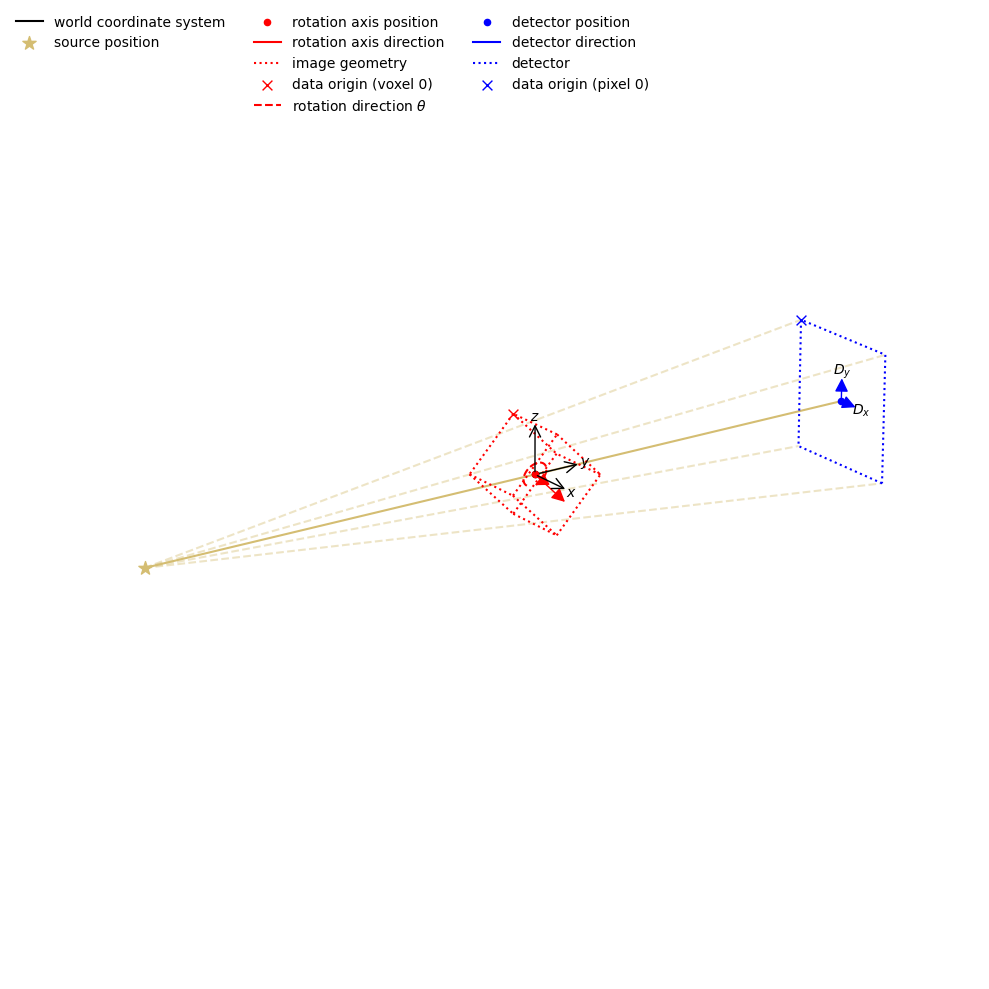

In [5]:
show_geometry(acquisition_geometry=ag,  view_distance=1);

### Read CL data

Number of dimensions: 3
Shape: (379, 1000, 1000)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



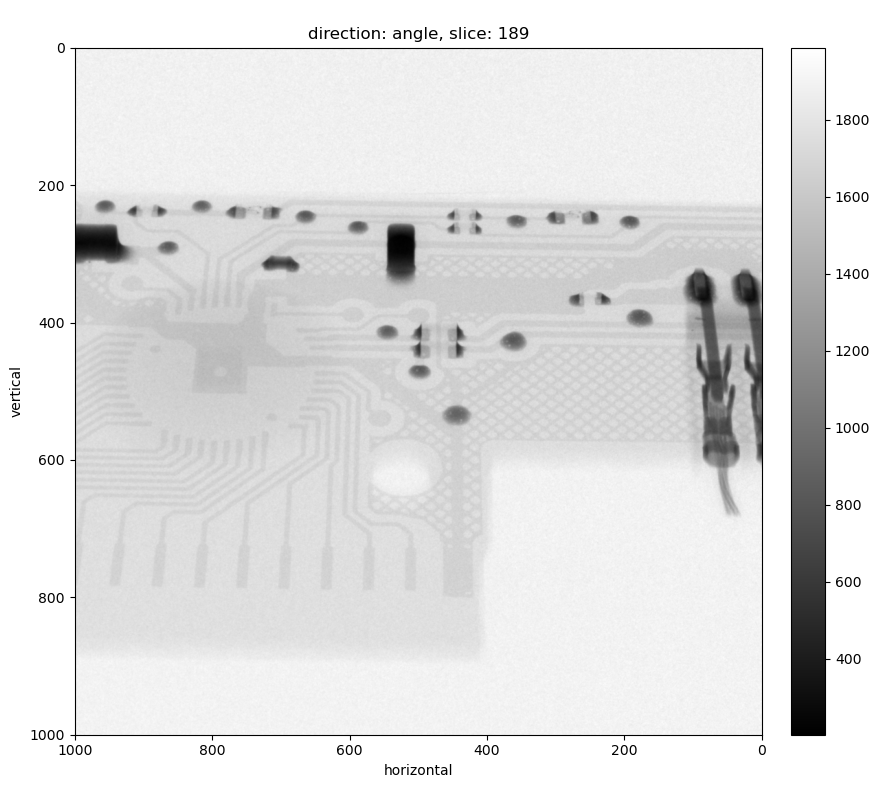

In [6]:
from util.readData import read_cl_data

filename = "../keyboard_4"
skip = 2 # Angle list downsampling parameter
crop = 0 # Image cropping parameter

acq_data = read_cl_data(filename=filename, acquisition_geometry=ag, skip=skip, crop=crop) # Acquisition data

### Transmission data to absorption data

Converting transmission data to absorption using Beer-Lambert's law

white_level = 1992, about 12.158 of the maximum (of 14 bit int)


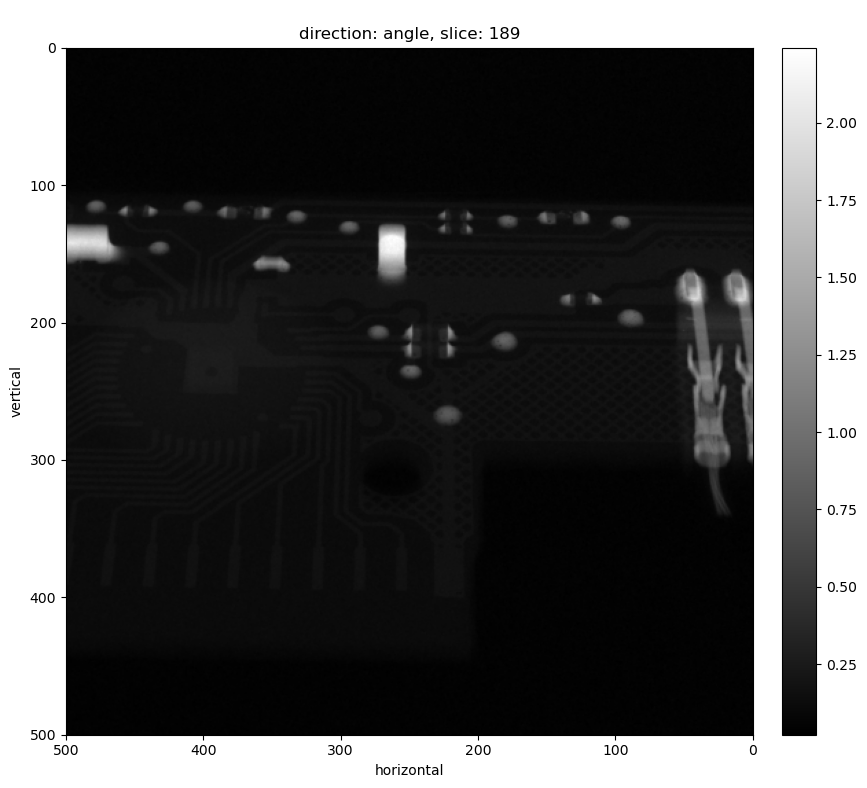

Number of dimensions: 3
Shape: (379, 500, 500)
Axis labels: (<AcquisitionDimension.ANGLE: 'angle'>, <AcquisitionDimension.VERTICAL: 'vertical'>, <AcquisitionDimension.HORIZONTAL: 'horizontal'>)



In [ ]:
from util.convertData import convert_cl_data

binning = 2 # Downsampling parameter for the acquisition data

abs_data = convert_cl_data(acquisition_data=acq_data, white_level=intensity, binning_parameter=binning)

### Reconstruction with FDK algorithm

In [8]:
reconstructor = FDK(abs_data)
FDK_recon = reconstructor.run()

FDK recon

Input Data:
	angle: 379
	vertical: 500
	horizontal: 500

Reconstruction Volume:
	vertical: 500
	horizontal_y: 500
	horizontal_x: 500

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 10
	Filter_inplace: False



In [9]:
islicer(FDK_recon, direction=2)

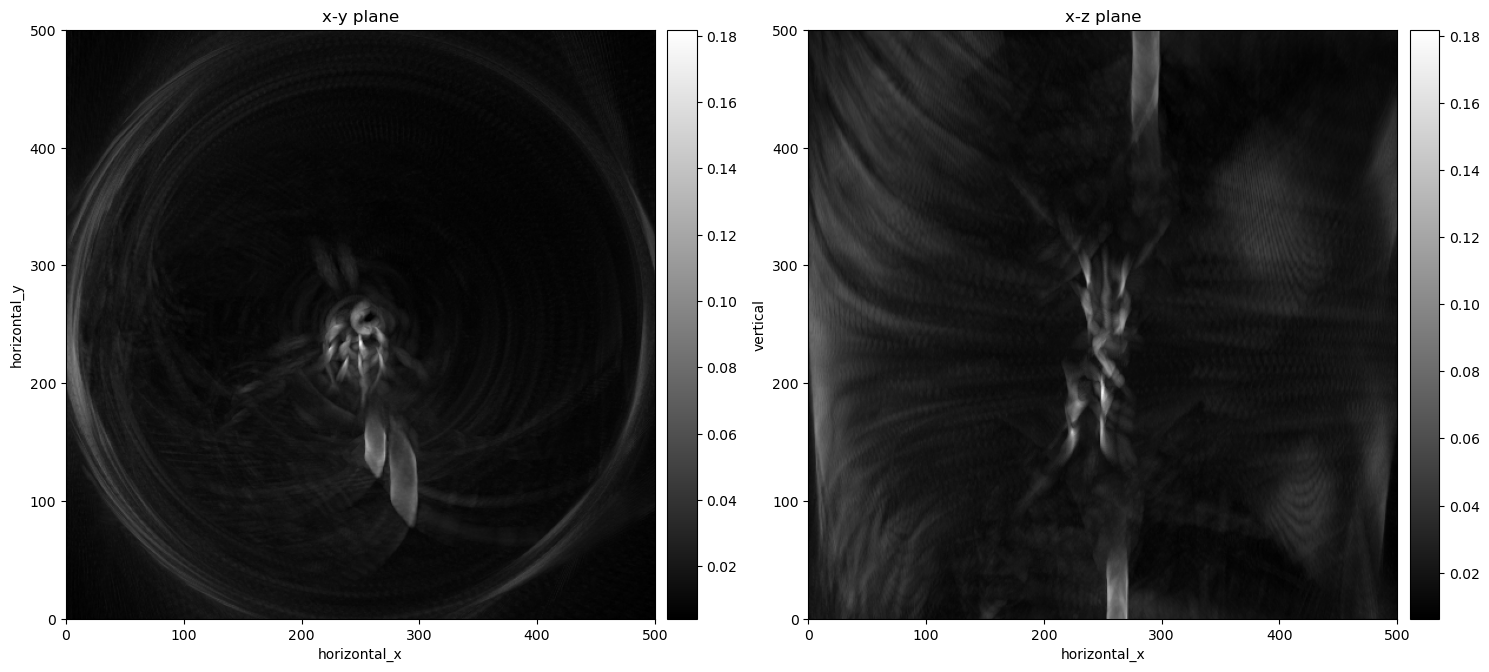

In [10]:
show2D([FDK_recon.max(axis=0),FDK_recon.max(axis=1)],title=['x-y plane','x-z plane'])

### Set Image geometry

Number of channels: 1
channel_spacing: 1.0
voxel_num : x707,y707,z100
voxel_size : x0.21549828805231855,y0.21549828805231855,z0.21549828805231855
center : x0,y0,z0



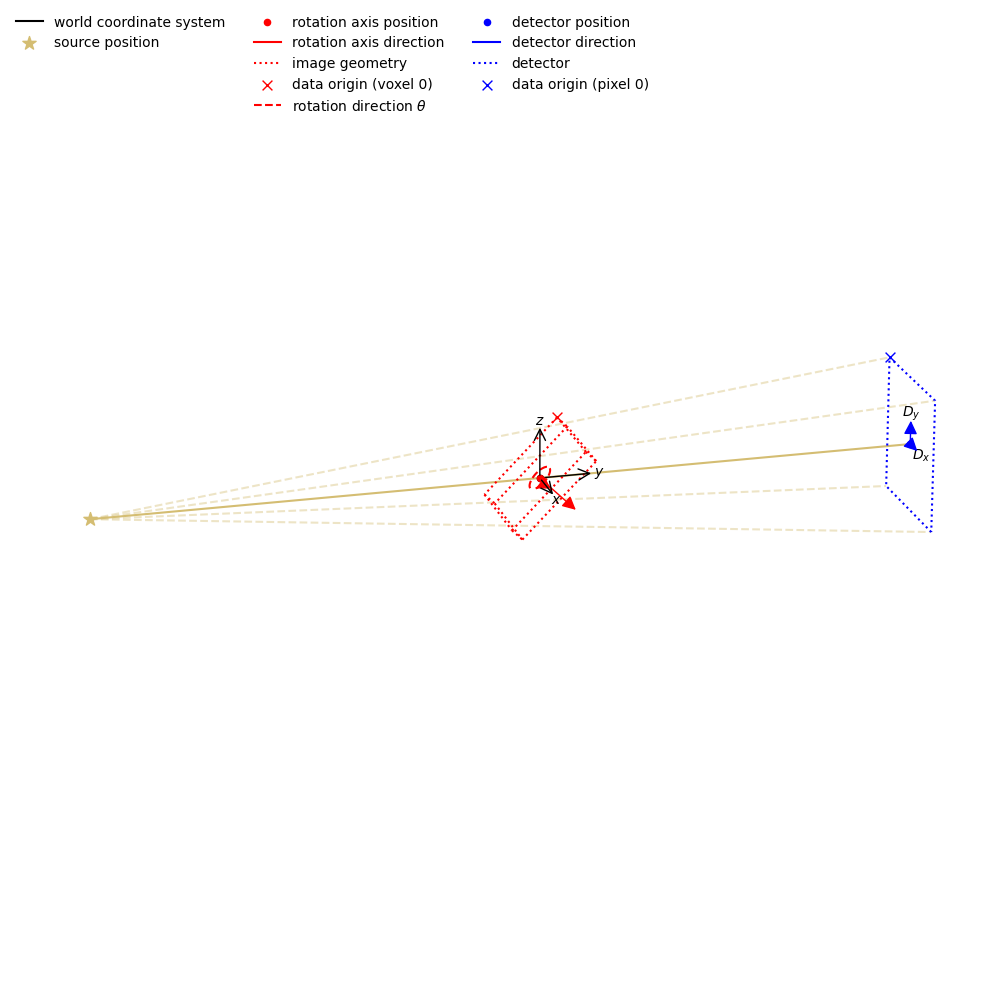

<class 'int'>


In [11]:
abs_data.reorder('astra')
ag = abs_data.geometry

ig = ag.get_ImageGeometry()
ig.voxel_num_z = 100
xy_slanted = int(ig.voxel_num_x / np.sin(tilt))
ig.voxel_num_x = xy_slanted
ig.voxel_num_y = xy_slanted
print(ig)
show_geometry(ag, ig, azimuthal=-15)

print(type(xy_slanted))

### Reconstruction with iterative methods

1. Unregularized Least Squares

In [ ]:
A = ProjectionOperator(image_geometry=ig, acquisition_geometry=ag, device='gpu')
LS = LeastSquares(A=A, b=abs_data)

fista_ls = FISTA(initial = ig.allocate(0), f = LS, g = ZeroFunction(), update_objective_interval = 10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
fista_ls.run(iterations=100)

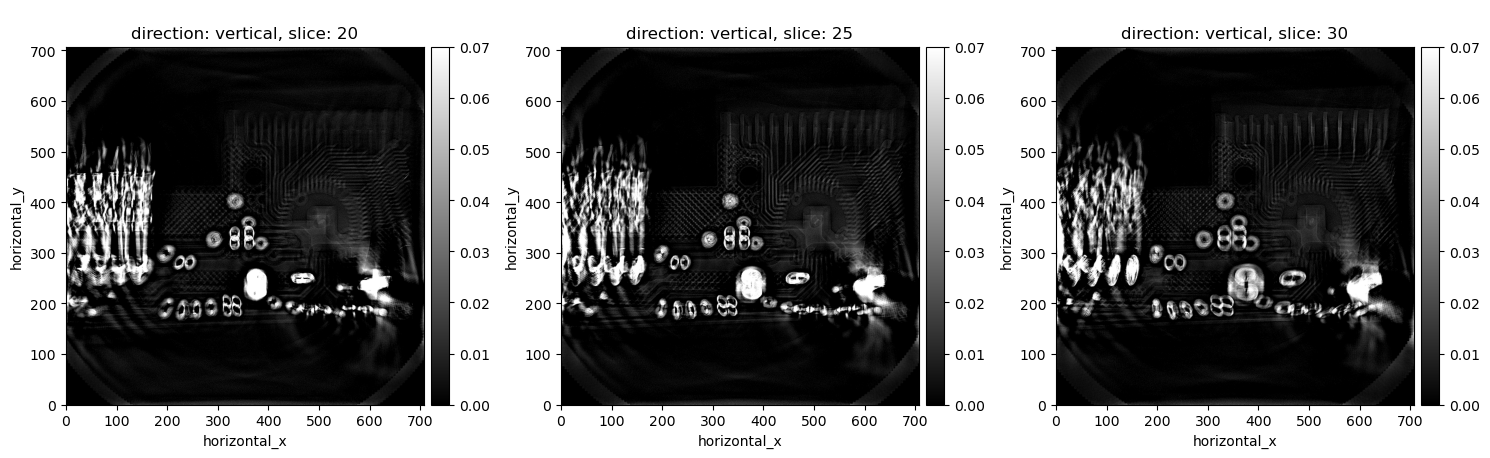

In [ ]:
LS_recon = fista_ls.solution
show2D(LS_recon, slice_list=[20, 25, 30], fix_range=(0, 0.07), num_cols=3);

2. Regularized Least Squares with Total Variation

In [ ]:
alpha = 0.02
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')
fista_tv = FISTA(initial=ig.allocate(0), f = LS, g = TV, update_objective_interval = 10)
fista_tv.run(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
h = TotalVariation()
alpha = 0.05
tv_fista = FISTA(initial=ig.allocate(0), f = LS, g = alpha*h, update_objective_interval = 10)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
tv_fista.run(10)

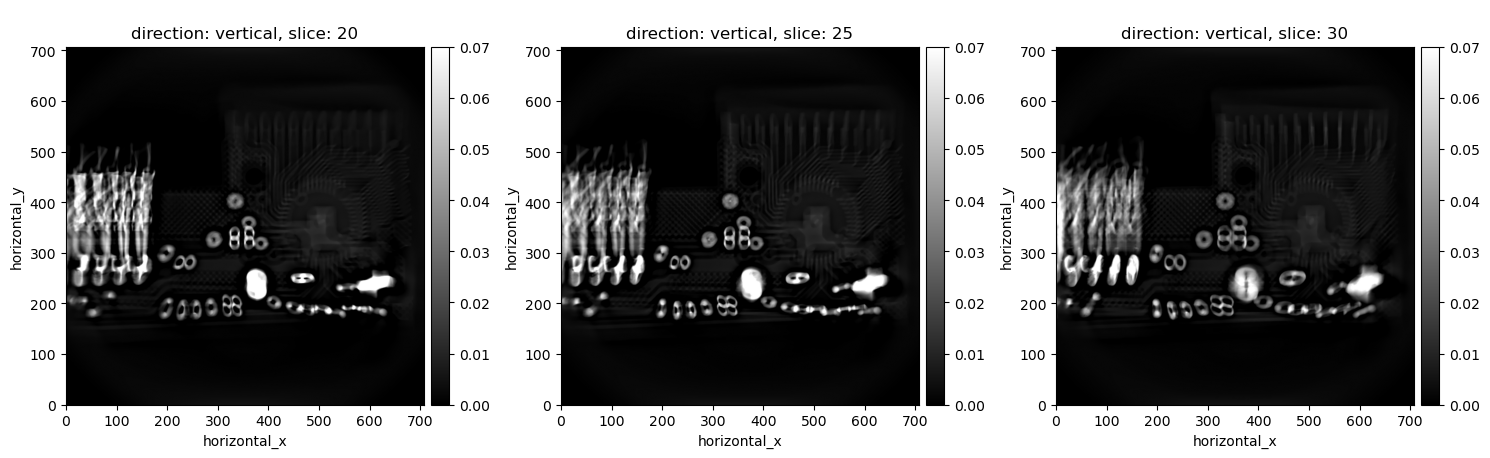

In [ ]:
tv_recon = tv_fista.solution
show2D(tv_recon, slice_list=[20, 25, 30], fix_range=(0, 0.07), num_cols=3);

In [31]:
islicer(tv_recon, direction=0, minmax=(0, 0.07))


3. PDHG

In [17]:
from cil.optimisation.operators import BlockOperator, GradientOperator
from cil.optimisation.algorithms import PDHG
from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox

D = GradientOperator(ig)
F = BlockFunction(L2NormSquared(b=abs_data), alpha*MixedL21Norm())
K = BlockOperator(A, D)
G = IndicatorBox()

pdhg_tv = PDHG(f = F, g = G, operator = K, update_objective_interval = 10, check_convergence = False)

In [18]:
pdhg_tv.run(100, verbose=1)

  0%|          | 0/100 [00:00<?, ?it/s]

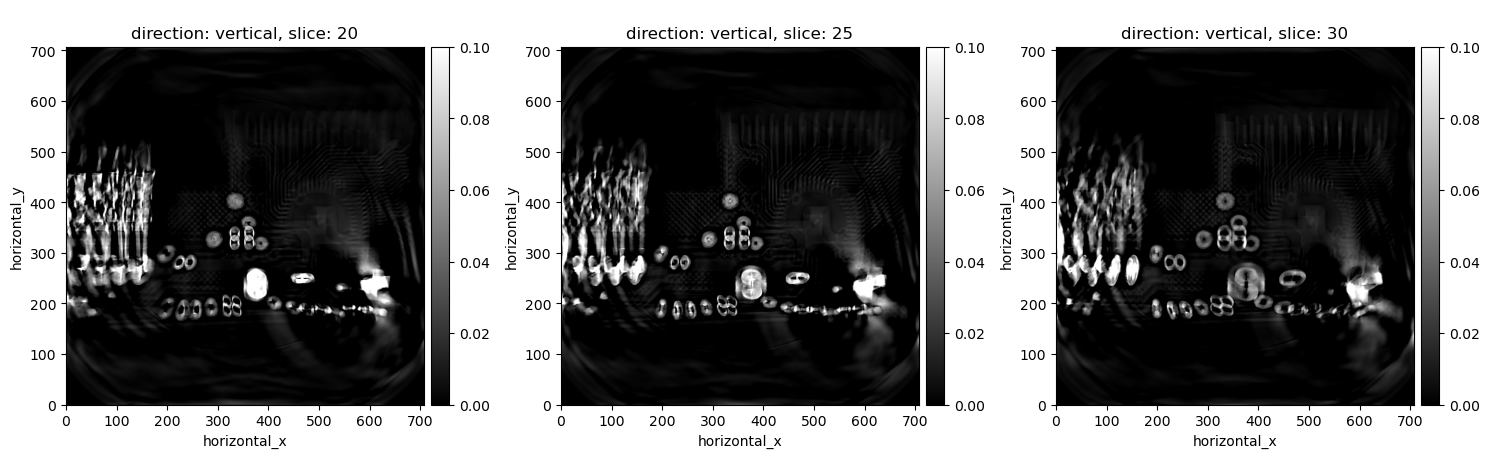

In [37]:
pdhg_recon = pdhg_tv.solution
show2D(pdhg_recon, slice_list=[20, 25, 30], fix_range=(0, 0.1), num_cols=3);

In [ ]:
islicer(pdhg_recon, direction=0, minmax=(0, 0.1))

4. SPDHG

In [ ]:
n_subsets = 10
partitioned_data = abs_data.partition(num_batches=n_subsets, mode='sequential')

f_subsets = []

for i in range(n_subsets):

    fi = 0.5*L2NormSquared(b = partitioned_data[i])
    f_subsets.append(fi)


F = BlockFunction(*f_subsets)
ageom_subset = partitioned_data.geometry
K = ProjectionOperator(image_geometry=ig, acquisition_geometry=ageom_subset)
G = alpha * FGP_TV(nonnegativity=True)

In [ ]:
from cil.optimisation.algorithms import SPDHG

spdhg = SPDHG(f = F, g = G, operator = K, update_objective_interval = 10)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
spdhg.run(50)

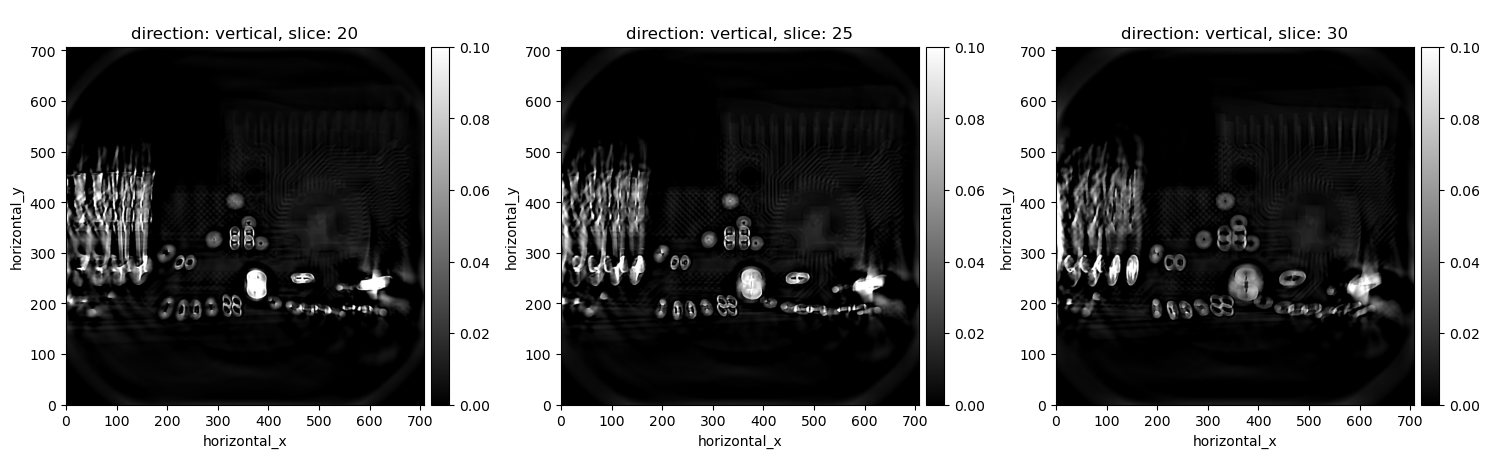

In [46]:
spdhg_recon = spdhg.solution
show2D(spdhg_recon, slice_list=[20, 25, 30], fix_range=(0, 0.1), num_cols=3);

In [ ]:
islicer(spdhg_recon, direction=0, minmax=(0, 0.08))